### Windsat training   
Training notebook with windsat dataset, to experiment with model architecture, sample selection an hyperparameters.

In [1]:
import xbatcher as xb
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import itertools

from datetime import datetime
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, Input, BatchNormalization
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import History

import sys
sys.path.append("../../")

from src.processing import windsat_datacube, create_landmask
from src.model import transform_batch, xy_split, default_model, default_model, plot_history

In [3]:
# default model can be overrrided later.
model = default_model()

def training_step(training_batch: pd.DataFrame, history: History=None ) -> History :
    """ 
    Single training step with a dataframe 2000 samples long. returned expanded history
    """
    X, y = xy_split(training_batch)
    x_train, x_test, y_train, y_test = train_test_split(X,y, test_size = 0.1, random_state = 13)
    batch_history = model.fit(x_train, y_train, epochs=10, validation_data=(x_test,y_test))

    # Manage the history of each training run
    if history is None:
        history = batch_history
    else:
        for key in history.history.keys():
            history.history[key].extend(batch_history.history[key])

    return history

In [2]:
#Load the dataset from the folder
folder_path = "../../data/raw/Daily_Windsat/"
ds = windsat_datacube(folder_path)
ds

<xarray.Dataset> Size: 3GB
Dimensions:         (day_number: 21, longitude_grid: 1440, latitude_grid: 720,
                     swath_sector: 2, frequency_band: 2, polarization: 2)
Coordinates:
    lat             (latitude_grid) float32 3kB dask.array<chunksize=(720,), meta=np.ndarray>
    lon             (longitude_grid) float32 6kB dask.array<chunksize=(1440,), meta=np.ndarray>
  * day_number      (day_number) int32 84B 1 2 3 4 5 6 7 ... 16 17 18 19 20 21
Dimensions without coordinates: longitude_grid, latitude_grid, swath_sector,
                                frequency_band, polarization
Data variables: (12/13)
    longitude       (day_number, longitude_grid) float32 121kB dask.array<chunksize=(1, 1440), meta=np.ndarray>
    latitude        (day_number, latitude_grid) float32 60kB dask.array<chunksize=(1, 720), meta=np.ndarray>
    node            (day_number, swath_sector) int32 168B dask.array<chunksize=(1, 2), meta=np.ndarray>
    frequency_vpol  (day_number, frequency_band) float32 168B dask.array<chunksize=(1, 2), meta=np.ndarray>
    frequency_hpol  (day_number, frequency_band) float32 168B dask.array<chunksize=(1, 2), meta=np.ndarray>
    eia_nominal     (day_number, frequency_band) float32 168B dask.array<chunksize=(1, 2), meta=np.ndarray>
    ...              ...
    eaa             (day_number, frequency_band, latitude_grid, longitude_grid, swath_sector) float32 348MB dask.array<chunksize=(1, 1, 360, 720, 1), meta=np.ndarray>
    eia             (day_number, frequency_band, latitude_grid, longitude_grid, swath_sector) float32 348MB dask.array<chunksize=(1, 1, 360, 720, 1), meta=np.ndarray>
    tbtoa           (day_number, polarization, frequency_band, latitude_grid, longitude_grid, swath_sector) float32 697MB dask.array<chunksize=(1, 1, 1, 240, 480, 1), meta=np.ndarray>
    quality_flag    (day_number, latitude_grid, longitude_grid, swath_sector) int32 174MB dask.array<chunksize=(1, 360, 720, 1), meta=np.ndarray>
    surtep_ERA5     (day_number, latitude_grid, longitude_grid, swath_sector) float32 174MB dask.array<chunksize=(1, 360, 720, 1), meta=np.ndarray>
    airtep_ERA5     (day_number, latitude_grid, longitude_grid, swath_sector) float32 174MB dask.array<chunksize=(1, 360, 720, 1), meta=np.ndarray>
Attributes: (12/72)
    Conventions:                            CF-1.7
    title:                                  RSS WindSat TOA Brightness Temper...
    version:                                V01.0
    summary:                                The dataset contains RSS WindSat ...
    references:                              [1] T. Meissner et al., Remote S...
    acknowledgement:                        Funded under NASA Grant 80NSSC21K...
    ...                                     ...
    Source_of_ancillary_IMERG_rain_rate:    Huffman, G. et al.,  2019. NASA G...
    Source_of_ancillary_CCMP_wind:          Mears, C. et al., 2023.Remote Sen...
    Source_of_ancillary_ERA5:               ECMWF Reanalysis v5 (ERA5). https...
    Source_of_RSS_WindSat_AS_ECV:           https://www.remss.com/missions/wi...
    Source_of_ancillary_HYCOM_SSS:          Hybrid Coordinate Ocean Model, Gl...
    Source_of_WindSat_L1C_TB:               T. Meissner et al., Remote Sensin...

In [3]:
# Preprocess and select the dataset
landmask = create_landmask(lon=ds.lon.values, lat=ds.lat.values)
ds["landmask"] = (("latitude_grid", "longitude_grid"), landmask.values)

#I talked with maria and we can create a "snow mask" by filtering surtep_ERA5 > 2ºC

# Filter the dataset for land, then select the ascending pass
ascds = ds.where(ds.landmask == 0).sel(swath_sector=0)

# select data only where era5 surtep is avobe 2ºC
ascds = ascds.where(ascds.surtep_ERA5 >(273.15 + 2))

# Select only desired variables
variables = ["time","tbtoa", "surtep_ERA5"]
ascds = ascds[variables]

# Split tbtoa and time into polarization and frequency
ascds["tbtoa_18Ghz_V"] = ascds.tbtoa.sel(polarization=0,frequency_band=0)
ascds["tbtoa_18Ghz_H"] = ascds.tbtoa.sel(polarization=1,frequency_band=0)
ascds["tbtoa_37Ghz_V"] = ascds.tbtoa.sel(polarization=0,frequency_band=1)
ascds["tbtoa_37Ghz_H"] = ascds.tbtoa.sel(polarization=1,frequency_band=1)

ascds["time_18Ghz"] = ascds.time.sel(frequency_band=0)
ascds["time_37Ghz"] = ascds.time.sel(frequency_band=1)

# Drop the original dvars
ascds = ascds.drop_vars(names=["tbtoa","time"])

# Lat and lon should be dvars instead
ascds = ascds.reset_coords(names = ["lat","lon"])

# Add longitude_grid and latitude_grid as indeces 
ascds = ascds.assign_coords(latitude_grid=range(720), longitude_grid=range(1440))
ascds = ascds.set_index(latitude_grid='latitude_grid', longitude_grid='longitude_grid')

ascds

<xarray.Dataset> Size: 784MB
Dimensions:         (day_number: 21, latitude_grid: 720, longitude_grid: 1440)
Coordinates:
  * day_number      (day_number) int32 84B 1 2 3 4 5 6 7 ... 16 17 18 19 20 21
  * latitude_grid   (latitude_grid) int32 3kB 0 1 2 3 4 ... 715 716 717 718 719
  * longitude_grid  (longitude_grid) int32 6kB 0 1 2 3 4 ... 1436 1437 1438 1439
Data variables:
    surtep_ERA5     (day_number, latitude_grid, longitude_grid) float32 87MB dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    lat             (latitude_grid) float32 3kB dask.array<chunksize=(720,), meta=np.ndarray>
    lon             (longitude_grid) float32 6kB dask.array<chunksize=(1440,), meta=np.ndarray>
    tbtoa_18Ghz_V   (day_number, latitude_grid, longitude_grid) float32 87MB dask.array<chunksize=(1, 240, 480), meta=np.ndarray>
    tbtoa_18Ghz_H   (day_number, latitude_grid, longitude_grid) float32 87MB dask.array<chunksize=(1, 240, 480), meta=np.ndarray>
    tbtoa_37Ghz_V   (day_number, latitude_grid, longitude_grid) float32 87MB dask.array<chunksize=(1, 240, 480), meta=np.ndarray>
    tbtoa_37Ghz_H   (day_number, latitude_grid, longitude_grid) float32 87MB dask.array<chunksize=(1, 240, 480), meta=np.ndarray>
    time_18Ghz      (day_number, latitude_grid, longitude_grid) float64 174MB dask.array<chunksize=(1, 240, 480), meta=np.ndarray>
    time_37Ghz      (day_number, latitude_grid, longitude_grid) float64 174MB dask.array<chunksize=(1, 240, 480), meta=np.ndarray>
Attributes: (12/72)
    Conventions:                            CF-1.7
    title:                                  RSS WindSat TOA Brightness Temper...
    version:                                V01.0
    summary:                                The dataset contains RSS WindSat ...
    references:                              [1] T. Meissner et al., Remote S...
    acknowledgement:                        Funded under NASA Grant 80NSSC21K...
    ...                                     ...
    Source_of_ancillary_IMERG_rain_rate:    Huffman, G. et al.,  2019. NASA G...
    Source_of_ancillary_CCMP_wind:          Mears, C. et al., 2023.Remote Sen...
    Source_of_ancillary_ERA5:               ECMWF Reanalysis v5 (ERA5). https...
    Source_of_RSS_WindSat_AS_ECV:           https://www.remss.com/missions/wi...
    Source_of_ancillary_HYCOM_SSS:          Hybrid Coordinate Ocean Model, Gl...
    Source_of_WindSat_L1C_TB:               T. Meissner et al., Remote Sensin...

--- 
IDEA
---

Xarray documentation says I can index datsets using pandas indexing ds.iloc[].
Maybe I can create a list of random (day_num, latgrid,longrid) and randomly slice the dataset by using that.

In [6]:
ds.isel(day_number = [1,3], latitude_grid = [24,25,27,28,30,32], longitude_grid = [12,23,54])

<xarray.Dataset> Size: 5kB
Dimensions:         (day_number: 2, longitude_grid: 3, latitude_grid: 6,
                     swath_sector: 2, frequency_band: 2, polarization: 2)
Coordinates:
    lat             (latitude_grid) float32 24B dask.array<chunksize=(6,), meta=np.ndarray>
    lon             (longitude_grid) float32 12B dask.array<chunksize=(3,), meta=np.ndarray>
  * day_number      (day_number) int32 8B 2 4
Dimensions without coordinates: longitude_grid, latitude_grid, swath_sector,
                                frequency_band, polarization
Data variables: (12/14)
    longitude       (day_number, longitude_grid) float32 24B dask.array<chunksize=(1, 3), meta=np.ndarray>
    latitude        (day_number, latitude_grid) float32 48B dask.array<chunksize=(1, 6), meta=np.ndarray>
    node            (day_number, swath_sector) int32 16B dask.array<chunksize=(1, 2), meta=np.ndarray>
    frequency_vpol  (day_number, frequency_band) float32 16B dask.array<chunksize=(1, 2), meta=np.ndarray>
    frequency_hpol  (day_number, frequency_band) float32 16B dask.array<chunksize=(1, 2), meta=np.ndarray>
    eia_nominal     (day_number, frequency_band) float32 16B dask.array<chunksize=(1, 2), meta=np.ndarray>
    ...              ...
    eia             (day_number, frequency_band, latitude_grid, longitude_grid, swath_sector) float32 576B dask.array<chunksize=(1, 1, 6, 3, 1), meta=np.ndarray>
    tbtoa           (day_number, polarization, frequency_band, latitude_grid, longitude_grid, swath_sector) float32 1kB dask.array<chunksize=(1, 1, 1, 6, 3, 1), meta=np.ndarray>
    quality_flag    (day_number, latitude_grid, longitude_grid, swath_sector) int32 288B dask.array<chunksize=(1, 6, 3, 1), meta=np.ndarray>
    surtep_ERA5     (day_number, latitude_grid, longitude_grid, swath_sector) float32 288B dask.array<chunksize=(1, 6, 3, 1), meta=np.ndarray>
    airtep_ERA5     (day_number, latitude_grid, longitude_grid, swath_sector) float32 288B dask.array<chunksize=(1, 6, 3, 1), meta=np.ndarray>
    landmask        (latitude_grid, longitude_grid) float64 144B nan nan ... nan
Attributes: (12/72)
    Conventions:                            CF-1.7
    title:                                  RSS WindSat TOA Brightness Temper...
    version:                                V01.0
    summary:                                The dataset contains RSS WindSat ...
    references:                              [1] T. Meissner et al., Remote S...
    acknowledgement:                        Funded under NASA Grant 80NSSC21K...
    ...                                     ...
    Source_of_ancillary_IMERG_rain_rate:    Huffman, G. et al.,  2019. NASA G...
    Source_of_ancillary_CCMP_wind:          Mears, C. et al., 2023.Remote Sen...
    Source_of_ancillary_ERA5:               ECMWF Reanalysis v5 (ERA5). https...
    Source_of_RSS_WindSat_AS_ECV:           https://www.remss.com/missions/wi...
    Source_of_ancillary_HYCOM_SSS:          Hybrid Coordinate Ocean Model, Gl...
    Source_of_WindSat_L1C_TB:               T. Meissner et al., Remote Sensin...

In [20]:
import random
# see where do we have data
has_data = ~np.isnan(ascds.tbtoa_37Ghz_H.values)

# Also remove the pixels with snow (TRUE = avobe 2ºC aka not snow)
snow_flag = (ascds.surtep_ERA5 > (273.15 + 2)).values

# Create the object with of all possible day-latg-long values (cartesian product)
all_indeces = list(itertools.product(
        ds.day_number.values,
        ds.latitude_grid.values,
        ds.longitude_grid.values
        )
)
print(len(all_indeces))
random.shuffle(all_indeces)

batch_indeces = all_indeces[:20]
batch_indeces

21772800
21772800
21772800


[(3, 315, 1185),
 (14, 641, 358),
 (13, 132, 631),
 (7, 212, 1201),
 (12, 570, 578),
 (20, 620, 1390),
 (6, 380, 411),
 (5, 443, 472),
 (5, 471, 1242),
 (6, 550, 1242),
 (17, 355, 201),
 (19, 45, 602),
 (5, 568, 1211),
 (9, 183, 650),
 (5, 461, 749),
 (21, 393, 888),
 (12, 495, 822),
 (12, 110, 646),
 (13, 510, 360),
 (6, 427, 19)]

# Hint! 
use random.sample to select an ordered, random sample of indeces, then remove them from the list and repeat untill none remain.

IDEA:

remove from the all_index list all the nan and snow indeces



In [22]:
# Select a batch from the dataset using batch_size
batch_size = 150
start = 1234
batch_indeces = sorted(all_indeces[start:start+batch_size])

days,latgs,longs = zip(*batch_indeces)

batch_ds = ascds.sel(day_number=sorted(days), latitude_grid=sorted(latgs), longitude_grid=sorted(longs))

# batch_ds = batch_ds.reset_index(["day_number","latitude_grid","longitude_grid"])
# batch_ds = batch_ds.reset_coords(["day_number","latitude_grid","longitude_grid"])

batch_ds

<xarray.Dataset> Size: 122MB
Dimensions:         (day_number: 150, latitude_grid: 150, longitude_grid: 150)
Coordinates:
  * day_number      (day_number) int32 600B 1 1 1 1 1 1 1 ... 21 21 21 21 21 21
  * latitude_grid   (latitude_grid) int32 600B 2 5 10 11 12 ... 696 709 712 718
  * longitude_grid  (longitude_grid) int32 600B 17 17 24 33 ... 1417 1424 1436
Data variables:
    surtep_ERA5     (day_number, latitude_grid, longitude_grid) float32 14MB dask.array<chunksize=(9, 81, 72), meta=np.ndarray>
    lat             (latitude_grid) float32 600B dask.array<chunksize=(150,), meta=np.ndarray>
    lon             (longitude_grid) float32 600B dask.array<chunksize=(150,), meta=np.ndarray>
    tbtoa_18Ghz_V   (day_number, latitude_grid, longitude_grid) float32 14MB dask.array<chunksize=(9, 58, 48), meta=np.ndarray>
    tbtoa_18Ghz_H   (day_number, latitude_grid, longitude_grid) float32 14MB dask.array<chunksize=(9, 58, 48), meta=np.ndarray>
    tbtoa_37Ghz_V   (day_number, latitude_grid, longitude_grid) float32 14MB dask.array<chunksize=(9, 58, 48), meta=np.ndarray>
    tbtoa_37Ghz_H   (day_number, latitude_grid, longitude_grid) float32 14MB dask.array<chunksize=(9, 58, 48), meta=np.ndarray>
    time_18Ghz      (day_number, latitude_grid, longitude_grid) float64 27MB dask.array<chunksize=(9, 58, 48), meta=np.ndarray>
    time_37Ghz      (day_number, latitude_grid, longitude_grid) float64 27MB dask.array<chunksize=(9, 58, 48), meta=np.ndarray>
Attributes: (12/72)
    Conventions:                            CF-1.7
    title:                                  RSS WindSat TOA Brightness Temper...
    version:                                V01.0
    summary:                                The dataset contains RSS WindSat ...
    references:                              [1] T. Meissner et al., Remote S...
    acknowledgement:                        Funded under NASA Grant 80NSSC21K...
    ...                                     ...
    Source_of_ancillary_IMERG_rain_rate:    Huffman, G. et al.,  2019. NASA G...
    Source_of_ancillary_CCMP_wind:          Mears, C. et al., 2023.Remote Sen...
    Source_of_ancillary_ERA5:               ECMWF Reanalysis v5 (ERA5). https...
    Source_of_RSS_WindSat_AS_ECV:           https://www.remss.com/missions/wi...
    Source_of_ancillary_HYCOM_SSS:          Hybrid Coordinate Ocean Model, Gl...
    Source_of_WindSat_L1C_TB:               T. Meissner et al., Remote Sensin...

In [23]:
batch_df = batch_ds.to_dataframe()
batch_df.reset_index(inplace=True)
batch_df.dropna(inplace=True)
batch_df.drop(columns=["longitude_grid","latitude_grid"], inplace=True)
batch_df = transform_batch(batch_df)
batch_df

,day_number,surtep_ERA5,lat,lon,tbtoa_18Ghz_V,tbtoa_18Ghz_H,tbtoa_37Ghz_V,tbtoa_37Ghz_H,time_18Ghz,time_37Ghz
7348,1,291.038727,-0.651105,0.067580,276.967499,270.507507,278.164978,273.354980,0.944210,0.943915
7647,1,290.558167,-0.634393,0.098017,275.125000,269.609985,278.062500,275.092499,0.943736,0.943456
7797,1,290.558167,-0.634393,0.098017,275.125000,269.609985,278.062500,275.092499,0.943736,0.943456
7847,1,295.162048,-0.613941,-0.871428,287.742493,280.065002,286.549988,281.829987,-0.375662,-0.374934
7848,1,292.531403,-0.613941,-0.856042,283.880005,277.437500,282.224976,278.269989,-0.376120,-0.375399
...,...,...,...,...,...,...,...,...,...,...
3371027,21,275.452515,0.830256,0.231323,261.747498,255.895004,263.179993,259.005005,-0.954009,-0.954259
3371474,21,277.362823,0.851498,0.106698,220.852493,177.262497,233.440002,195.479996,-0.954862,-0.955081
3371772,21,276.473083,0.877774,0.093674,245.845001,221.647491,253.149994,234.717499,-0.955943,-0.956164
3371922,21,276.473083,0.877774,0.093674,245.845001,221.647491,253.149994,234.717499,-0.955943,-0.956164


How viable is to select a single point, turn it into a dataframe and concatenate them ? 

In [24]:
# # Select a batch from the dataset using batch_size
# batch_size = 1
# start = 1237
# batch_indeces = all_indeces[start:start+batch_size]

# days,latgs,longs = zip(*batch_indeces)

# batch_ds = ascds.sel(day_number=sorted(days), latitude_grid=sorted(latgs), longitude_grid=sorted(longs))
# batch_df = batch_ds.to_dataframe()
# batch_df.reset_index(inplace=True)
# batch_df.drop(columns=["longitude_grid","latitude_grid"], inplace=True)
# batch_df = transform_batch(batch_df)
# batch_df

In [12]:
batch_ds

<xarray.Dataset> Size: 56B
Dimensions:         (day_number: 1, latitude_grid: 1, longitude_grid: 1)
Coordinates:
  * day_number      (day_number) int32 4B 3
  * latitude_grid   (latitude_grid) int32 4B 383
  * longitude_grid  (longitude_grid) int32 4B 799
Data variables:
    surtep_ERA5     (day_number, latitude_grid, longitude_grid) float32 4B dask.array<chunksize=(1, 1, 1), meta=np.ndarray>
    lat             (latitude_grid) float32 4B dask.array<chunksize=(1,), meta=np.ndarray>
    lon             (longitude_grid) float32 4B dask.array<chunksize=(1,), meta=np.ndarray>
    tbtoa_18Ghz_V   (day_number, latitude_grid, longitude_grid) float32 4B dask.array<chunksize=(1, 1, 1), meta=np.ndarray>
    tbtoa_18Ghz_H   (day_number, latitude_grid, longitude_grid) float32 4B dask.array<chunksize=(1, 1, 1), meta=np.ndarray>
    tbtoa_37Ghz_V   (day_number, latitude_grid, longitude_grid) float32 4B dask.array<chunksize=(1, 1, 1), meta=np.ndarray>
    tbtoa_37Ghz_H   (day_number, latitude_grid, longitude_grid) float32 4B dask.array<chunksize=(1, 1, 1), meta=np.ndarray>
    time_18Ghz      (day_number, latitude_grid, longitude_grid) float64 8B dask.array<chunksize=(1, 1, 1), meta=np.ndarray>
    time_37Ghz      (day_number, latitude_grid, longitude_grid) float64 8B dask.array<chunksize=(1, 1, 1), meta=np.ndarray>
Attributes: (12/72)
    Conventions:                            CF-1.7
    title:                                  RSS WindSat TOA Brightness Temper...
    version:                                V01.0
    summary:                                The dataset contains RSS WindSat ...
    references:                              [1] T. Meissner et al., Remote S...
    acknowledgement:                        Funded under NASA Grant 80NSSC21K...
    ...                                     ...
    Source_of_ancillary_IMERG_rain_rate:    Huffman, G. et al.,  2019. NASA G...
    Source_of_ancillary_CCMP_wind:          Mears, C. et al., 2023.Remote Sen...
    Source_of_ancillary_ERA5:               ECMWF Reanalysis v5 (ERA5). https...
    Source_of_RSS_WindSat_AS_ECV:           https://www.remss.com/missions/wi...
    Source_of_ancillary_HYCOM_SSS:          Hybrid Coordinate Ocean Model, Gl...
    Source_of_WindSat_L1C_TB:               T. Meissner et al., Remote Sensin...

In [25]:
# # Try to retrieve only the pixels in the list

# # Select a batch from the dataset using batch_size
# batch_size = 500
# start = 1237
# batch_indeces = sorted(all_indeces[start:start+batch_size])

# # TODO make this into a function (indeces -> dataframe)
# batch = []
# for latg,long in batch_indeces:
#     ds = ascds.sel(latitude_grid=[latg], longitude_grid=[long])
#     batch.append(ds.to_dataframe())

# batch_df = pd.concat(batch)
# batch_df.reset_index(inplace=True)
# batch_df.drop(columns=["longitude_grid","latitude_grid"], inplace=True)
# batch_df = transform_batch(batch_df)
# #######################################################3

# batch_df



In [13]:
# # We will convert the batches into dataframes for training with this custom function
# batch_df = batch_example.to_dataframe()
# batch_df = transform_batch(batch_df)
# batch_df

In [31]:
#OPTIONAL: define a custom model to train:
n_vars = batch_df.shape[1] - 1 # dont count the prediction column.

model = Sequential([
    Input((n_vars,)),
    BatchNormalization(),
    Dense(30,activation="relu", name = "hiddenLayer1"),
    Dense(20,activation="relu", name = "hiddenLayer2"),
    Dense(10,activation="relu", name = "hiddenLayer3"),
    Dense(1,activation="relu", name = "outputLayer")
])

model.compile(
    optimizer = "adam",
    loss ="mse",
    metrics = ["mse"]
)
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_4           │ (None, 9)              │            36 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hiddenLayer1 (Dense)            │ (None, 30)             │           300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hiddenLayer2 (Dense)            │ (None, 20)             │           620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hiddenLayer3 (Dense)            │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputLayer (Dense)             │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,177 (4.60 KB)

 Trainable params: 1,159 (4.53 KB)

 Non-trainable params: 18 (72.00 B)

In [110]:
# #TODO: refactor this function later
# def get_batch_dataframe(batch_indeces, ascds):
#     batch = []
#     for latg,long in batch_indeces:
#         ds = ascds.sel(latitude_grid=[latg], longitude_grid=[long])
#         batch.append(ds.to_dataframe())

#     batch_df = pd.concat(batch)
#     batch_df.reset_index(inplace=True)
#     batch_df.drop(columns=["longitude_grid","latitude_grid"], inplace=True)
#     batch_df = transform_batch(batch_df)

#     return batch_df

In [27]:
# #  Compleately Random batch training loop :
# batch_size = 250 # Samples in (day, lat, lon) !(len(ds) = batch_size**3)
# history=None

# for i in range(0, len(all_indeces), batch_size):

#     # Skip the last chunk if is not big enought
#     if (i + batch_size) > len(all_indeces) - 1:
#         break

#     # batch_indeces = all_indeces[i:i+batch_size]

#     # Retrieve the dataset with the indeces
#     batch_indeces = sorted(all_indeces[i:i+batch_size])

#     # days,latgs,longs = zip(*batch_indeces)
#     # batch_ds = ascds.sel(day_number=list(days), latitude_grid=list(latgs), longitude_grid=list(longs))

#     # # Transform it into a dataframe and transform it
#     # batch_df = batch_ds.to_dataframe()
#     # batch_df.reset_index(inplace=True)
#     # batch_df.dropna(inplace=True) 
#     # batch_df.drop(columns=["longitude_grid","latitude_grid"], inplace=True)
#     # batch_df = transform_batch(batch_df)

#     batch_df = get_batch_dataframe(batch_indeces, ascds)
    
#     # Train the model for an epoch:
#     history = training_step(batch_df, history)

#     print(f"Standard Batch {(i+1)//batch_size} out of {len(all_indeces)//batch_size} - {100*(i+1)/(len(all_indeces)):.2f}%")

individually selecting each pixel is too slow. Maybe we can get away by selecting a random range of latg and long for all days.

The provious method is not great either. We select all possible combinations of the selected lat, lon and day. which adds a lot of nans what we have to remove and the samples are potentially selected more than once.

We can redesing the indeces to work on slices:

- select all "l" days in every sample
- select "n" random latitude grid indeces 
- select "m" random longitude grid indeces 

the selection has l x n x m samples (~2/3 of those are nans)



In [28]:
# Random batch training loop :
batch_size = 200 # Samples in (day, lat, lon) !(len(ds) = batch_size**3)
history=None

for i in range(0, len(all_indeces), batch_size):

    # Skip the last chunk if is not big enought
    if (i + batch_size) > len(all_indeces) - 1:
        break

    # Retrieve the dataset with the indeces
    batch_indeces = all_indeces[i:i+batch_size]

    days, latgs,longs = zip(*batch_indeces)
    batch_ds = ascds.sel(day_number=sorted(days),latitude_grid=sorted(latgs), longitude_grid=sorted(longs))

    # Transform it into a dataframe and transform it
    batch_df = batch_ds.to_dataframe()
    batch_df.reset_index(inplace=True)
    batch_df.dropna(inplace=True) 
    batch_df.drop(columns=["longitude_grid","latitude_grid"], inplace=True)
    batch_df = transform_batch(batch_df)

    
    # Train the model for an epoch:
    history = training_step(batch_df, history)

    print(f"Standard Batch {(i+1)//batch_size} out of {len(all_indeces)//batch_size} - {100*(i+1)/(len(all_indeces)):.2f}%")

Epoch 1/10
5918/5918 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 11294.9463 - mse: 11294.9463 - val_loss: 21.9672 - val_mse: 21.9672
Epoch 2/10
5918/5918 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 23.9904 - mse: 23.9904 - val_loss: 12.6075 - val_mse: 12.6075
Epoch 3/10
5918/5918 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 16.8711 - mse: 16.8711 - val_loss: 10.7103 - val_mse: 10.7103
Epoch 4/10
5918/5918 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 15.8859 - mse: 15.8859 - val_loss: 20.3664 - val_mse: 20.3664
Epoch 5/10
5918/5918 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 15.0799 - mse: 15.0799 - val_loss: 9.5375 - val_mse: 9.5375
Epoch 6/10
5918/5918 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 14.7656 - mse: 14.7656 - val_loss: 14.0066 - val_mse: 14.0066
Epoch 7/10
5918/5918 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 14.4442 - mse: 14.4442 - val_loss: 9.0697 - val_mse: 9.0697
Epoch 8/10
5918/5918 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 14.2025 - mse: 14.2025 - val_loss: 16.1384 - val_mse: 16.1384
Epoch 

KeyboardInterrupt: 

Too slow, implement the leftovers method

maybe we can get away with pseudo random selection of bathces ? 

select day range(bias,365, 10), select lat range(bias,720,72), select lon rage(bias,1440,144)

In [ ]:
# # Generate the batches using xbatch (outdated)
# bgen = xb.BatchGenerator(
#     ds=ascds,
#     input_dims ={"latitude_grid":100,"longitude_grid":100, "day_number":21},
#     )

In [ ]:
# # Leftovers training loop
# history = None
# min_samples = 2000 # model batch training is 32 by default, so this makes nice numbers appear.
# leftovers = pd.DataFrame()

# # TODO: make this sequential process into a parallel one (retrieve data - train model)
# for i, batch in enumerate(bgen):
#     batch = batch.to_dataframe()
#     batch = transform_batch(batch)

#     batch = pd.concat([leftovers,batch])
#     print(f"Standard Batch {i+1} out of {len(bgen)} - {100*(i+1)/len(bgen):.2f}%")


#     if batch.shape[0] < min_samples:
#         leftovers = pd.concat([leftovers,batch])
#         continue

#     training_batch, leftovers = batch[:min_samples], batch[min_samples:]

#     history = training_step(training_batch, history)

#     while leftovers.shape[0] > min_samples:
#         training_batch, new_leftovers = leftovers[:min_samples], leftovers[min_samples:]
#         history = training_step(training_batch, history)
#         leftovers = new_leftovers

#     print(f"Standard Batch {i+1} out of {len(bgen)} - {100*(i+1)/len(bgen):.2f}%")


In [29]:
# Save FINAL model weights and history data.
now = datetime.now().strftime(r"%Y_%m_%dT%H%M%S")

weights_path = f"../../models/{now}.weights.h5"
model.save_weights(weights_path)

history_path = f"../../models/{now}_history.json"
with open(history_path, "wb") as file:
    pickle.dump(history, file)

(<Figure size 2400x1000 with 2 Axes>,
 array([<Axes: xlabel='Epoch', ylabel='mse [K]'>,
        <Axes: xlabel='Epoch', ylabel='log_10(mse [K])'>], dtype=object))

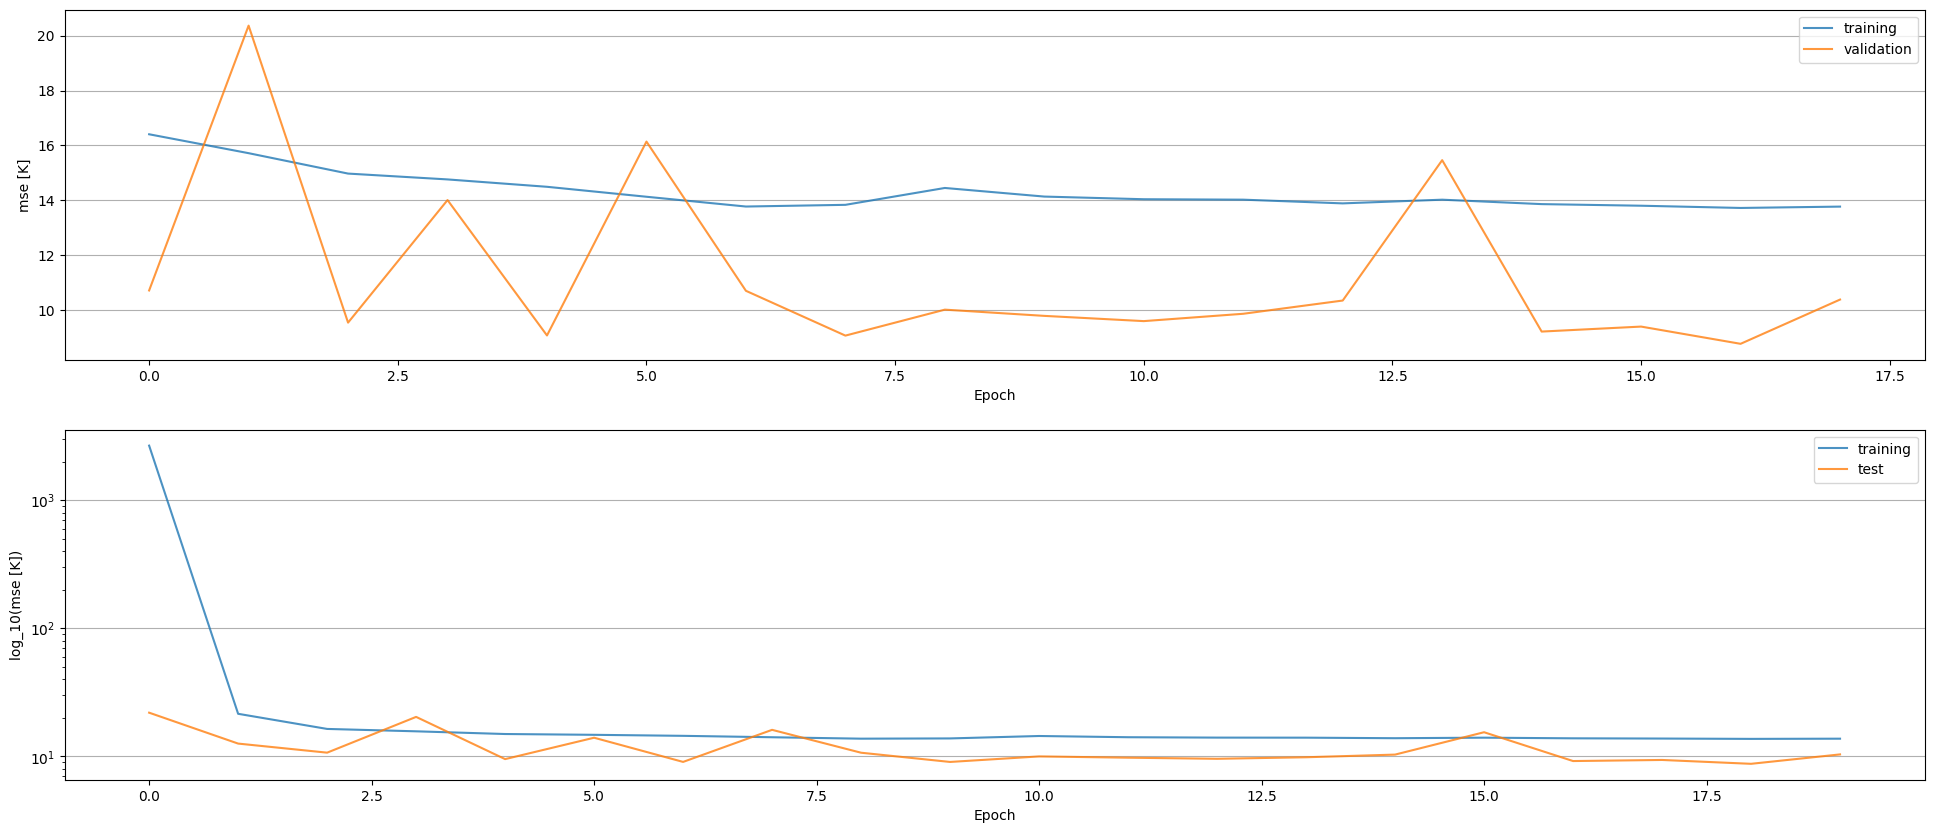

In [30]:
plot_history(history)

---

Some test on the results

In [5]:
# Predict the values for a single day:
sample = ascds.sel(day_number= np.random.randint(1,21))
sample_df = sample.to_dataframe()
sample_df = transform_batch(sample_df)
sample_df.shape

(1036800, 10)

In [6]:
X, _ = xy_split(sample_df)
y_pred =  model.predict(X)
sample_df["surtep_PRED"] = y_pred
sample_df["diff"] = sample_df["surtep_PRED"] - sample_df["surtep_ERA5"]
sample_df.columns

NameError: name 'model' is not defined

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


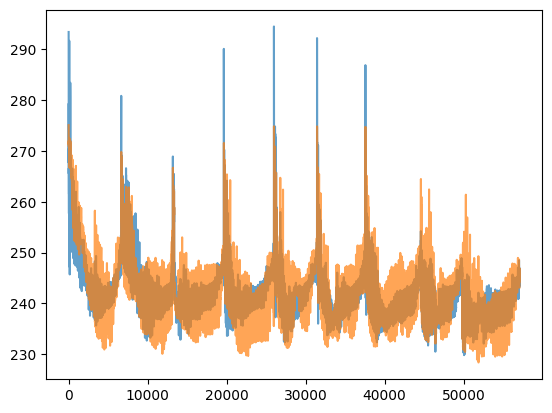

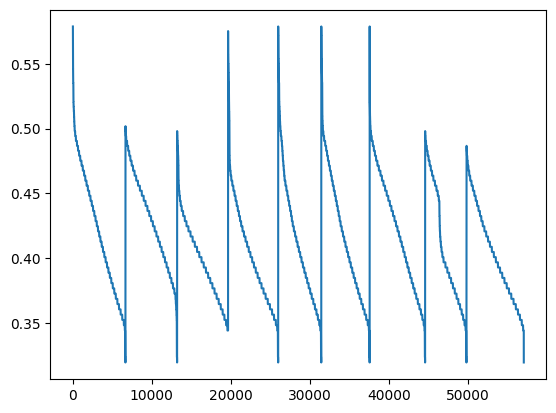

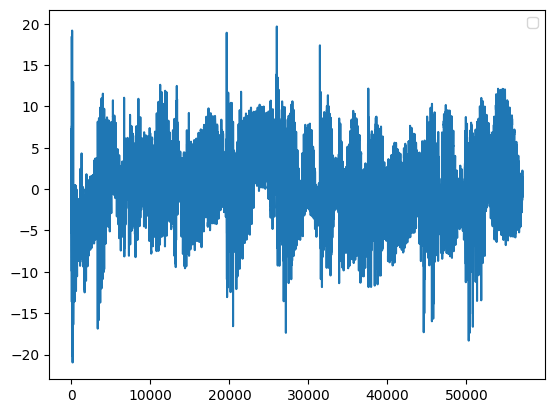

In [146]:
# difference = sample_df["diff"].values.reshape((72,144))
# plt.imshow(difference)
plot_df = sample_df[:] 
plt.plot(plot_df["surtep_PRED"],alpha=.7,label="prediction")
plt.plot(plot_df["surtep_ERA5"],alpha=0.7, label = "ERA5")
plt.figure()
plt.plot(plot_df["lat"])
plt.figure()
plt.plot(plot_df["diff"])
plt.legend()

Not the case, the model trained in this manner does not work at all

The lat-lon slicing creates uniform squares, so the model loss is low in some quadrants and high in others:

NEXT STEP:
    I believe that snow covered areas are causing a problem. 

    a) record the loss function for each batch and then plot it on a map

    b) selec only equatorial latitudes (-45,45) to see if results improve

---

Rethink the "random" sample method.

individually selecting each pixel is too slow. Maybe we can get away by selecting a random range of latg and long for all days.

The provious method is not great either. We select all possible combinations of the selected lat, lon and day. which adds a lot of nans what we have to remove and the samples are potentially selected more than once.

We can redesing the indeces to work on slices:

- select all "l" days in every sample
- select "n" random latitude grid indeces 
- select "m" random longitude grid indeces 

the selection has l x n x m samples (~2/3 of those are nans)


---

Lets just try to pass the entire thing into the dataframe


In [7]:
ascds_df = ascds.to_dataframe()
ascds_df.reset_index(inplace=True)
ascds_df.dropna(inplace=True)
ascds_df.drop(columns=["longitude_grid","latitude_grid"], inplace=True)
ascds_df = transform_batch(ascds_df)
ascds_df

,day_number,surtep_ERA5,lat,lon,tbtoa_18Ghz_V,tbtoa_18Ghz_H,tbtoa_37Ghz_V,tbtoa_37Ghz_H,time_18Ghz,time_37Ghz
212694,1,275.894440,-0.799947,0.959437,194.885010,127.485001,215.657501,163.107498,-0.498066,-0.498753
232835,1,276.849609,-0.761821,0.932796,211.529999,159.434998,230.509995,191.927490,-0.502751,-0.503454
232838,1,277.820099,-0.761821,0.937434,218.139999,172.832489,234.354996,200.334991,-0.502524,-0.503216
232839,1,278.050476,-0.761821,0.938944,217.937500,172.014999,234.285004,199.912506,-0.502455,-0.503140
232840,1,277.954346,-0.761821,0.940437,213.382492,163.179993,231.119995,193.644989,-0.502389,-0.503071
...,...,...,...,...,...,...,...,...,...,...
21661288,21,276.515686,0.943368,0.376629,202.862488,140.917496,215.862503,169.722504,-0.745851,-0.746355
21661289,21,275.758698,0.943368,0.380667,208.297485,151.820007,217.259995,175.607498,-0.745832,-0.746333
21705886,21,275.418823,0.979487,0.201505,196.614990,127.227493,208.505005,153.690002,-0.752623,-0.753145
21705887,21,275.177582,0.979487,0.205777,196.882492,127.707497,208.345001,153.547501,-0.752609,-0.753126


In [15]:
#OPTIONAL: define a custom model to train:
n_vars = ascds_df.shape[1] - 1 # dont count the prediction column.
history = None
model = Sequential([
    Input((n_vars,)),
    BatchNormalization(),
    Dense(32,activation="relu", name = "hiddenLayer1"),
    Dense(16,activation="relu", name = "hiddenLayer2"),
    Dense(8,activation="relu", name = "hiddenLayer3"),
    Dense(4,activation="relu", name = "hiddenLayer4"),
    Dense(2,activation="relu", name = "hiddenLayer5"),
    Dense(1,activation="relu", name = "outputLayer")
])

model.compile(
    optimizer = "adam",
    loss ="mse",
    metrics = ["mse"]
)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_1           │ (None, 9)              │            36 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hiddenLayer1 (Dense)            │ (None, 32)             │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hiddenLayer2 (Dense)            │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hiddenLayer3 (Dense)            │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hiddenLayer4 (Dense)            │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hiddenLayer5 (Dense)            │ (None, 2)              │            10 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputLayer (Dense)             │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,069 (4.18 KB)

 Trainable params: 1,051 (4.11 KB)

 Non-trainable params: 18 (72.00 B)

In [16]:
# model= default_model()

def training_step(training_batch: pd.DataFrame, history: History=None ) -> History :
    """ 
    Single training step with a dataframe 2000 samples long. returned expanded history
    """
    X, y = xy_split(training_batch)
    x_train, x_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 13)
    batch_history = model.fit(x_train, y_train, epochs=10, validation_data=(x_test,y_test))

    # Manage the history of each training run
    if history is None:
        history = batch_history
    else:
        for key in history.history.keys():
            history.history[key].extend(batch_history.history[key])

    return history

In [17]:
history = training_step(ascds_df, history)

Epoch 1/10
12512/12512 ━━━━━━━━━━━━━━━━━━━━ 20s 1ms/step - loss: 5706.3252 - mse: 5706.3252 - val_loss: 15.9440 - val_mse: 15.9440
Epoch 2/10
12512/12512 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step - loss: 16.8534 - mse: 16.8534 - val_loss: 9.7985 - val_mse: 9.7985
Epoch 3/10
12512/12512 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step - loss: 15.2954 - mse: 15.2954 - val_loss: 10.1293 - val_mse: 10.1293
Epoch 4/10
12512/12512 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step - loss: 14.9901 - mse: 14.9901 - val_loss: 10.2987 - val_mse: 10.2987
Epoch 5/10
12512/12512 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step - loss: 14.4867 - mse: 14.4867 - val_loss: 10.0470 - val_mse: 10.0470
Epoch 6/10
12512/12512 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step - loss: 14.1968 - mse: 14.1968 - val_loss: 8.7376 - val_mse: 8.7376
Epoch 7/10
12512/12512 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step - loss: 13.7225 - mse: 13.7225 - val_loss: 10.8901 - val_mse: 10.8901
Epoch 8/10
12512/12512 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step - loss: 13.7996 - mse: 13.7996 - val_loss: 8.8651 - va

In [ ]:
# Save FINAL model weights and history data.
now = datetime.now().strftime(r"%Y_%m_%dT%H%M%S")

weights_path = f"../../models/{now}.weights.h5"
model.save_weights(weights_path)

history_path = f"../../models/{now}_history.json"
with open(history_path, "wb") as file:
    pickle.dump(history, file)

(<Figure size 2400x1000 with 2 Axes>,
 array([<Axes: xlabel='Epoch', ylabel='mse [K]'>,
        <Axes: xlabel='Epoch', ylabel='log_10(mse [K])'>], dtype=object))

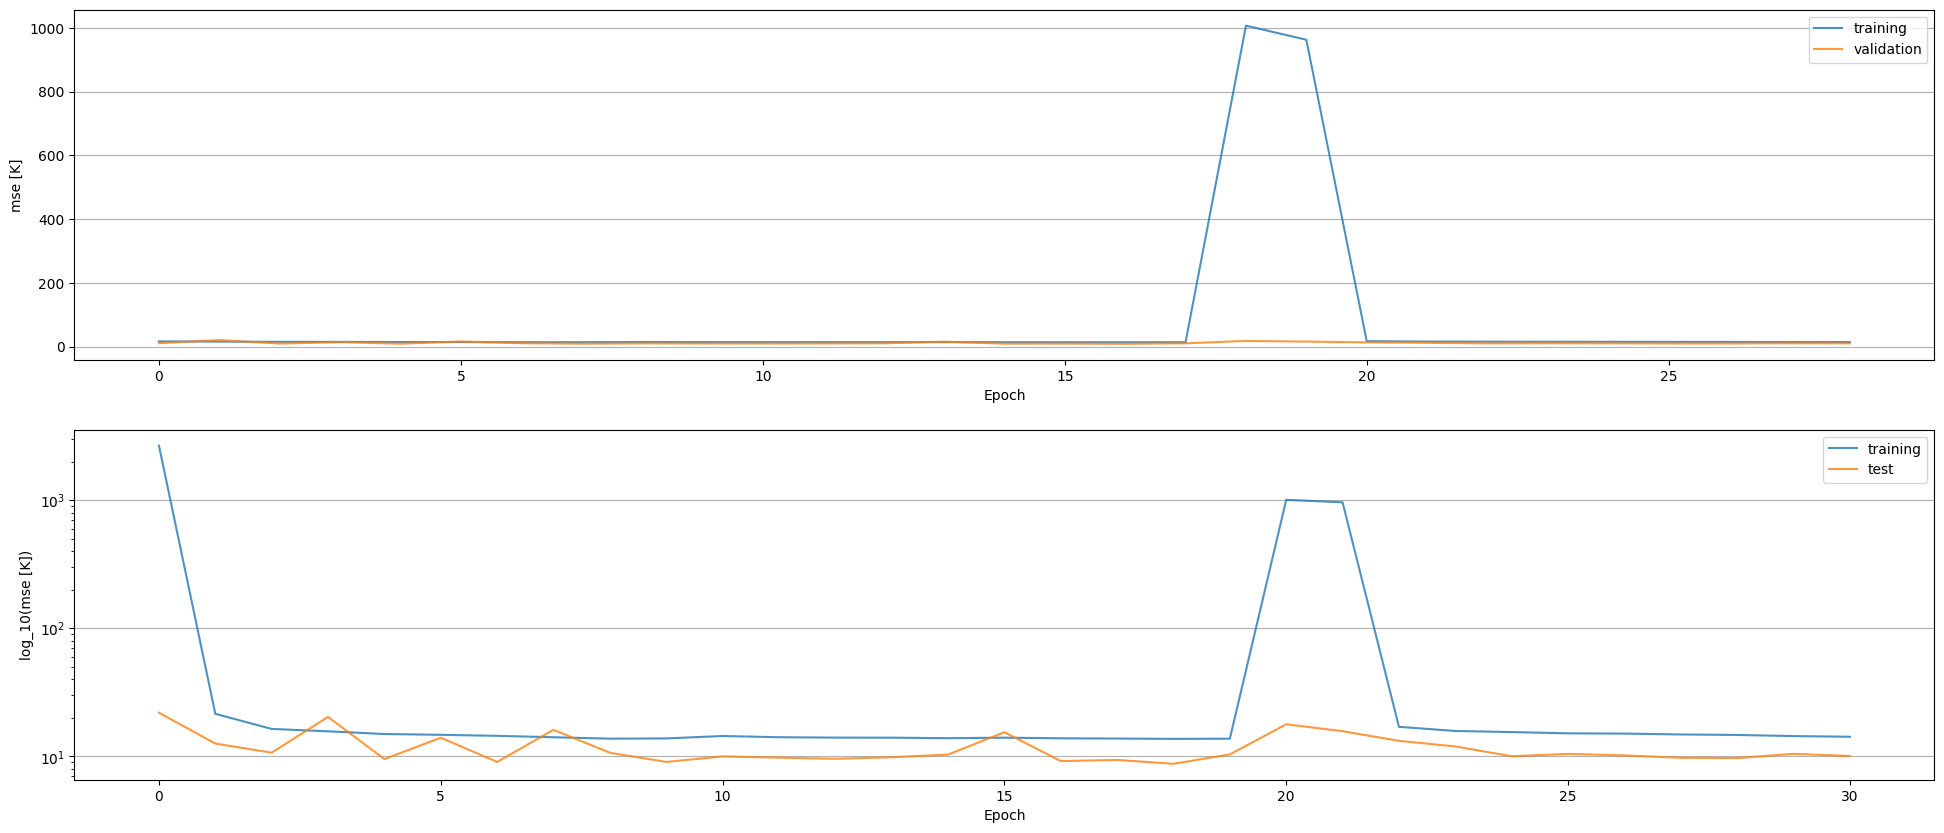

In [ ]:
plot_history(history)